In [1]:
import json
import numpy as np
import ijson
import os
from sklearn.decomposition import IncrementalPCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import joblib

In [2]:
batch_size = 1200  # Adjust based on your memory constraints
n_components = 200  # Number of components for PCA
max_clusters = 22  # Maximum number of clusters to evaluate

In [3]:
json_file_path = "extracted_features.json"
model_dir = "kmeans_models/"
os.makedirs(model_dir, exist_ok=True)

In [4]:
ipca = IncrementalPCA(n_components=n_components)

In [5]:
print("Fitting Incremental PCA in batches...")
with open(json_file_path, "r") as f:
    batch_data = []
    for idx, (img_name, features) in enumerate(ijson.kvitems(f, '')):
        features_np = np.array(features).flatten().reshape(1, -1)
        batch_data.append(features_np)

        if len(batch_data) >= batch_size:
            batch_array = np.vstack(batch_data)
            ipca.partial_fit(batch_array)
            batch_data = []

    if batch_data:
        batch_array = np.vstack(batch_data)
        ipca.partial_fit(batch_array)

print("Incremental PCA fitting completed.")

Fitting Incremental PCA in batches...
Incremental PCA fitting completed.


In [6]:
explained_variance_ratio = ipca.explained_variance_ratio_
total_explained_variance = np.cumsum(explained_variance_ratio)

print(f"Variance explained by 200 components: {total_explained_variance[199] * 100:.2f}%")

Variance explained by 200 components: 90.29%


In [7]:
wcss = []
silhouette_scores = []

In [8]:
for n_clusters in range(15, max_clusters + 1):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, random_state=42)

    batch_data = []
    reduced_data = []
    image_names = []

    print(f"Processing for {n_clusters} clusters...")
    
    with open(json_file_path, "r") as f:
        for idx, (img_name, features) in enumerate(ijson.kvitems(f, '')):
            features_np = np.array(features).flatten().reshape(1, -1)
            batch_data.append(features_np)
            image_names.append(img_name)

            if len(batch_data) >= batch_size:
                batch_array = np.vstack(batch_data)
                reduced_batch = ipca.transform(batch_array)
                kmeans.partial_fit(reduced_batch)
                reduced_data.extend(reduced_batch)
                batch_data = []

        if batch_data:
            batch_array = np.vstack(batch_data)
            reduced_batch = ipca.transform(batch_array)
            kmeans.partial_fit(reduced_batch)
            reduced_data.extend(reduced_batch)

    reduced_data = np.vstack(reduced_data)
    cluster_labels = kmeans.predict(reduced_data)

    # Save WCSS and Silhouette Score
    wcss.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    # Save the KMeans model
    model_path = os.path.join(model_dir, f"kmeans_{n_clusters}_clusters.pkl")
    joblib.dump(kmeans, model_path)
    print(f"Model with {n_clusters} clusters saved at {model_path}")


Processing for 15 clusters...


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Model with 15 clusters saved at kmeans_models/kmeans_15_clusters.pkl
Processing for 16 clusters...


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Model with 16 clusters saved at kmeans_models/kmeans_16_clusters.pkl
Processing for 17 clusters...


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Model with 17 clusters saved at kmeans_models/kmeans_17_clusters.pkl
Processing for 18 clusters...


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Model with 18 clusters saved at kmeans_models/kmeans_18_clusters.pkl
Processing for 19 clusters...


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Model with 19 clusters saved at kmeans_models/kmeans_19_clusters.pkl
Processing for 20 clusters...


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Model with 20 clusters saved at kmeans_models/kmeans_20_clusters.pkl
Processing for 21 clusters...


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Model with 21 clusters saved at kmeans_models/kmeans_21_clusters.pkl
Processing for 22 clusters...


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Model with 22 clusters saved at kmeans_models/kmeans_22_clusters.pkl


In [9]:
# Print the lengths of your data to see if they match
print("Length of WCSS:", len(wcss))
print("Length of Silhouette Scores:", len(silhouette_scores))
print("Range length:", len(range(2, max_clusters + 1)))

Length of WCSS: 8
Length of Silhouette Scores: 8
Range length: 21


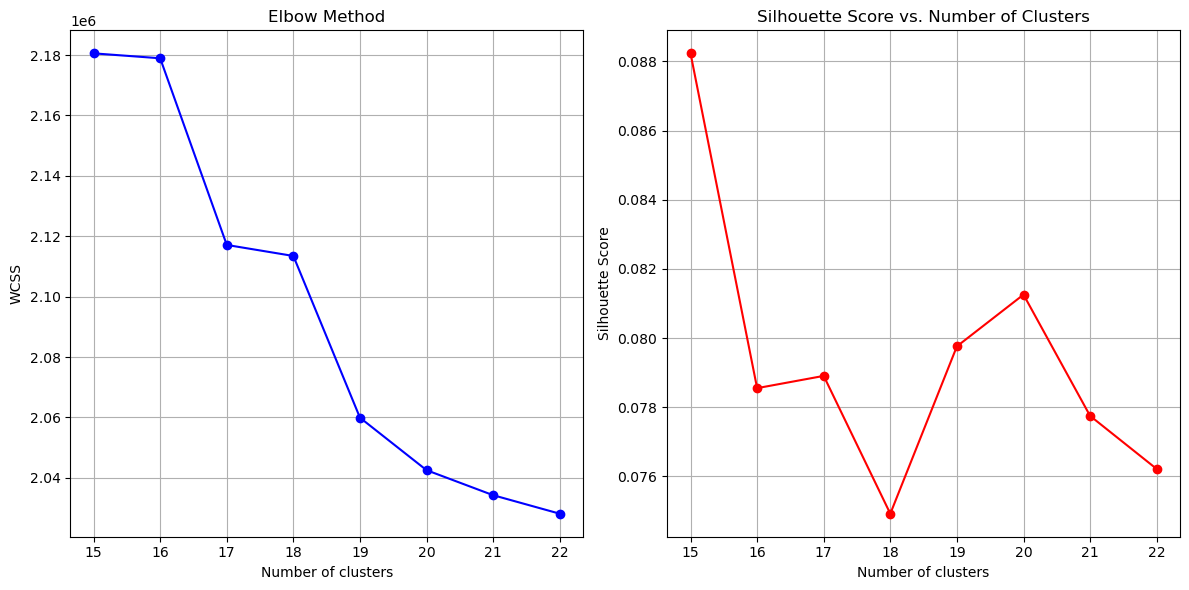

In [11]:
# Adjust `max_clusters` to the correct range based on the length of your WCSS and Silhouette Scores
plt.figure(figsize=(12, 6))

# Plot WCSS for the Elbow Method
plt.subplot(1, 2, 1)
plt.plot(range(15, 23), wcss, 'bo-', label='WCSS')  # Adjusted range to match WCSS length
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.grid(True)

# Plot Silhouette Score vs Number of Clusters
plt.subplot(1, 2, 2)
plt.plot(range(15, 23), silhouette_scores, 'ro-', label='Silhouette Score')  # Adjusted range to match Silhouette Scores length
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid(True)

plt.tight_layout()
plt.show()
